# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:09<00:00, 6.33KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

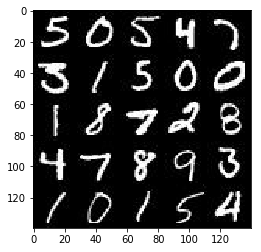

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

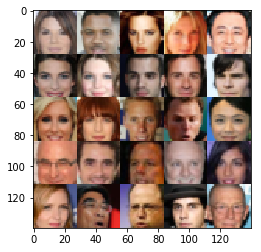

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [59]:
def leaky_relu(x, alpha=1e-1):
    return tf.maximum(alpha*x, x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        inp_shape = images.get_shape().as_list()
        n_channels = inp_shape[3]  # 3
        
        # good values: 16,
        n_filters = 64
        kernel_size = 3
        strides = (2,2)
        
        # 28x28x3
        c0 = tf.layers.conv2d(images, n_filters, kernel_size, strides=strides, padding='same')
        c0 = leaky_relu(c0)
        
        # 14x14x16
        n_filters *= 2
        c1 = tf.layers.conv2d(c0, n_filters, kernel_size, strides=strides, padding='same')
        c1 = tf.layers.batch_normalization(c1, training=True)
        c1 = leaky_relu(c1)
        
        # 7x7x32
        n_filters *= 2
        c2 = tf.layers.conv2d(c1, n_filters, kernel_size, strides=strides, padding='same')
        c2 = tf.layers.batch_normalization(c2, training=True)
        c2 = leaky_relu(c2)
        
        # 4x4x64
        c2_shape = c2.get_shape().as_list()
        flat = tf.reshape(c2, (-1, c2_shape[1] * c2_shape[2] * c2_shape[3]))
        logits = tf.layers.dense(flat, 1)
        out = tf.nn.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [56]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=not is_train):
        # TODO: Implement Function
        kernel_size = 3
        strides = (2,2)
        initial_kernel = 3
        
        # good values: 128, 256
        channels = 512

        x = tf.layers.dense(z, (initial_kernel**2)*channels)
        x = tf.layers.batch_normalization(x, training=is_train)
        x = leaky_relu(x)
        x = tf.reshape(x, (-1, initial_kernel, initial_kernel, channels))
        # 4x4x128

        channels //= 2
        c0 = tf.layers.conv2d_transpose(x, channels, kernel_size, strides=strides, padding='valid')
        c0 = tf.layers.batch_normalization(c0, training=is_train)
        c0 = leaky_relu(c0)
        # 7x7x64

        channels //= 2
        c1 = tf.layers.conv2d_transpose(c0, channels, kernel_size, strides=strides, padding='same')
        c1 = tf.layers.batch_normalization(c1, training=is_train)
        c1 = leaky_relu(c1)
        # 14x14x32

        c2 = tf.layers.conv2d_transpose(c1, out_channel_dim, kernel_size, strides=strides, padding='same')
        # 28x28x3

        return tf.tanh(c2)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [45]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    input_fake = generator(input_z, out_channel_dim, is_train=True)
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    d_out_fake, d_logits_fake = discriminator(input_fake, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

[None, 28, 28, 4]
[None, 28, 28, 4]
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [29]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
        return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [68]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        batch = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch += 1
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={
                    input_real: batch_images,
                    input_z: batch_z,
                    lr: learning_rate,
                })
                _ = sess.run(g_opt, feed_dict={
                    input_real: batch_images,
                    input_z: batch_z,
                    lr: learning_rate,
                })
                
                if batch % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if batch % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/10... Discriminator Loss: 0.0385... Generator Loss: 6.6881
Epoch 1/10... Discriminator Loss: 0.0175... Generator Loss: 10.3089
Epoch 1/10... Discriminator Loss: 0.0636... Generator Loss: 3.5829
Epoch 1/10... Discriminator Loss: 0.5359... Generator Loss: 10.0023
Epoch 1/10... Discriminator Loss: 0.3791... Generator Loss: 2.4722
Epoch 1/10... Discriminator Loss: 0.6081... Generator Loss: 5.4110
Epoch 1/10... Discriminator Loss: 0.3130... Generator Loss: 2.2453
Epoch 1/10... Discriminator Loss: 0.1296... Generator Loss: 3.0982
Epoch 1/10... Discriminator Loss: 0.7036... Generator Loss: 1.4244
Epoch 1/10... Discriminator Loss: 0.8671... Generator Loss: 1.0630


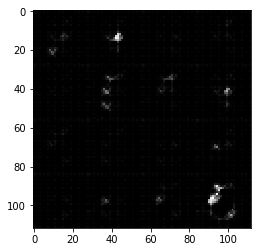

Epoch 1/10... Discriminator Loss: 0.1014... Generator Loss: 2.8858
Epoch 1/10... Discriminator Loss: 0.0458... Generator Loss: 3.9385
Epoch 1/10... Discriminator Loss: 0.0696... Generator Loss: 3.9942
Epoch 1/10... Discriminator Loss: 0.0544... Generator Loss: 3.4565
Epoch 1/10... Discriminator Loss: 0.0242... Generator Loss: 4.4049
Epoch 1/10... Discriminator Loss: 0.0195... Generator Loss: 4.6084
Epoch 1/10... Discriminator Loss: 0.3702... Generator Loss: 2.0818
Epoch 1/10... Discriminator Loss: 0.0469... Generator Loss: 3.7456
Epoch 1/10... Discriminator Loss: 0.4445... Generator Loss: 5.3324
Epoch 1/10... Discriminator Loss: 0.4260... Generator Loss: 1.4216


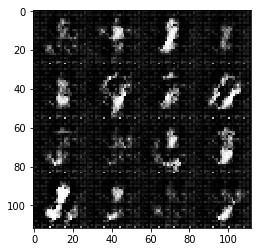

Epoch 1/10... Discriminator Loss: 1.0367... Generator Loss: 7.0512
Epoch 1/10... Discriminator Loss: 0.4902... Generator Loss: 1.3987
Epoch 1/10... Discriminator Loss: 0.8417... Generator Loss: 0.8781
Epoch 1/10... Discriminator Loss: 0.4201... Generator Loss: 3.1403
Epoch 1/10... Discriminator Loss: 0.5678... Generator Loss: 1.3814
Epoch 1/10... Discriminator Loss: 0.2147... Generator Loss: 2.0916
Epoch 1/10... Discriminator Loss: 0.6833... Generator Loss: 1.0492
Epoch 1/10... Discriminator Loss: 0.4367... Generator Loss: 1.7873
Epoch 1/10... Discriminator Loss: 1.2294... Generator Loss: 0.4357
Epoch 1/10... Discriminator Loss: 0.4016... Generator Loss: 1.6404


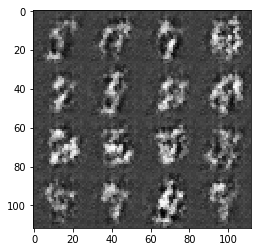

Epoch 1/10... Discriminator Loss: 0.1848... Generator Loss: 2.8543
Epoch 1/10... Discriminator Loss: 0.4223... Generator Loss: 1.5362
Epoch 1/10... Discriminator Loss: 0.6047... Generator Loss: 1.0283
Epoch 1/10... Discriminator Loss: 0.2642... Generator Loss: 1.9178
Epoch 1/10... Discriminator Loss: 0.3833... Generator Loss: 1.4596
Epoch 1/10... Discriminator Loss: 0.2389... Generator Loss: 1.9394
Epoch 1/10... Discriminator Loss: 0.2484... Generator Loss: 1.8559
Epoch 1/10... Discriminator Loss: 0.3087... Generator Loss: 1.6038
Epoch 1/10... Discriminator Loss: 0.6897... Generator Loss: 0.8560
Epoch 1/10... Discriminator Loss: 0.1627... Generator Loss: 2.3726


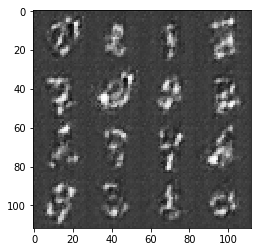

Epoch 1/10... Discriminator Loss: 0.0316... Generator Loss: 4.4552
Epoch 1/10... Discriminator Loss: 0.2208... Generator Loss: 1.8840
Epoch 1/10... Discriminator Loss: 0.3470... Generator Loss: 1.4660
Epoch 1/10... Discriminator Loss: 0.0956... Generator Loss: 2.7406
Epoch 1/10... Discriminator Loss: 0.0370... Generator Loss: 3.9922
Epoch 1/10... Discriminator Loss: 0.0498... Generator Loss: 4.1749
Epoch 1/10... Discriminator Loss: 0.0617... Generator Loss: 3.8682
Epoch 1/10... Discriminator Loss: 0.1664... Generator Loss: 2.6649
Epoch 1/10... Discriminator Loss: 2.1757... Generator Loss: 0.2275
Epoch 1/10... Discriminator Loss: 0.9044... Generator Loss: 1.3619


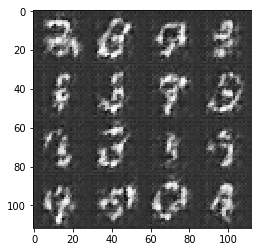

Epoch 1/10... Discriminator Loss: 0.7220... Generator Loss: 1.5285
Epoch 1/10... Discriminator Loss: 1.1338... Generator Loss: 0.4973
Epoch 1/10... Discriminator Loss: 0.6895... Generator Loss: 0.9989
Epoch 1/10... Discriminator Loss: 0.6432... Generator Loss: 1.7401
Epoch 1/10... Discriminator Loss: 0.6654... Generator Loss: 3.0525
Epoch 1/10... Discriminator Loss: 0.6719... Generator Loss: 1.1105
Epoch 1/10... Discriminator Loss: 0.4930... Generator Loss: 1.2750
Epoch 1/10... Discriminator Loss: 0.3496... Generator Loss: 2.4149
Epoch 1/10... Discriminator Loss: 0.4998... Generator Loss: 1.1968
Epoch 1/10... Discriminator Loss: 0.5619... Generator Loss: 1.1391


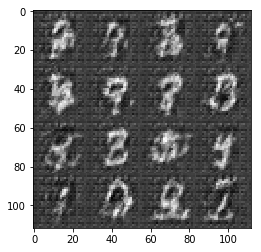

Epoch 1/10... Discriminator Loss: 0.3316... Generator Loss: 1.5983
Epoch 1/10... Discriminator Loss: 0.6895... Generator Loss: 1.0166
Epoch 1/10... Discriminator Loss: 0.3692... Generator Loss: 1.6579
Epoch 1/10... Discriminator Loss: 0.1284... Generator Loss: 3.0176
Epoch 1/10... Discriminator Loss: 0.1768... Generator Loss: 2.6341
Epoch 1/10... Discriminator Loss: 0.1472... Generator Loss: 2.7032
Epoch 1/10... Discriminator Loss: 0.0569... Generator Loss: 4.1469
Epoch 1/10... Discriminator Loss: 0.1395... Generator Loss: 4.3290
Epoch 1/10... Discriminator Loss: 0.2753... Generator Loss: 1.8133
Epoch 1/10... Discriminator Loss: 0.1037... Generator Loss: 3.1132


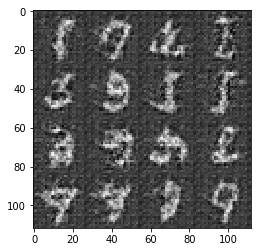

Epoch 1/10... Discriminator Loss: 0.0205... Generator Loss: 6.3631
Epoch 1/10... Discriminator Loss: 0.4461... Generator Loss: 1.2775
Epoch 1/10... Discriminator Loss: 0.1018... Generator Loss: 3.1672
Epoch 1/10... Discriminator Loss: 0.0350... Generator Loss: 6.5656
Epoch 1/10... Discriminator Loss: 0.0579... Generator Loss: 4.0063
Epoch 1/10... Discriminator Loss: 1.8301... Generator Loss: 8.7541
Epoch 1/10... Discriminator Loss: 2.5390... Generator Loss: 0.1379
Epoch 1/10... Discriminator Loss: 1.0897... Generator Loss: 0.6027
Epoch 1/10... Discriminator Loss: 1.1779... Generator Loss: 3.0352
Epoch 1/10... Discriminator Loss: 1.9200... Generator Loss: 0.2414


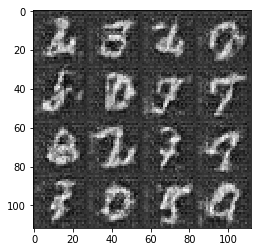

Epoch 1/10... Discriminator Loss: 0.8008... Generator Loss: 0.8843
Epoch 1/10... Discriminator Loss: 1.5472... Generator Loss: 0.3144
Epoch 1/10... Discriminator Loss: 0.6249... Generator Loss: 2.5047
Epoch 1/10... Discriminator Loss: 1.2437... Generator Loss: 0.4592
Epoch 1/10... Discriminator Loss: 0.9995... Generator Loss: 0.6208
Epoch 1/10... Discriminator Loss: 0.4696... Generator Loss: 1.5747
Epoch 1/10... Discriminator Loss: 0.3772... Generator Loss: 2.2787
Epoch 1/10... Discriminator Loss: 0.4945... Generator Loss: 1.8119
Epoch 1/10... Discriminator Loss: 0.2837... Generator Loss: 2.6618
Epoch 1/10... Discriminator Loss: 0.2264... Generator Loss: 2.3611


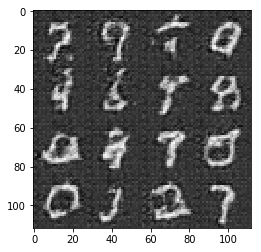

Epoch 1/10... Discriminator Loss: 0.6481... Generator Loss: 0.9317
Epoch 1/10... Discriminator Loss: 0.8972... Generator Loss: 0.6692
Epoch 1/10... Discriminator Loss: 0.3276... Generator Loss: 1.7592
Epoch 2/10... Discriminator Loss: 1.3563... Generator Loss: 5.7201
Epoch 2/10... Discriminator Loss: 0.3350... Generator Loss: 1.5994
Epoch 2/10... Discriminator Loss: 0.2087... Generator Loss: 2.1652
Epoch 2/10... Discriminator Loss: 0.0740... Generator Loss: 3.5409
Epoch 2/10... Discriminator Loss: 0.1200... Generator Loss: 3.0269
Epoch 2/10... Discriminator Loss: 0.1628... Generator Loss: 5.5343
Epoch 2/10... Discriminator Loss: 0.1175... Generator Loss: 3.2623


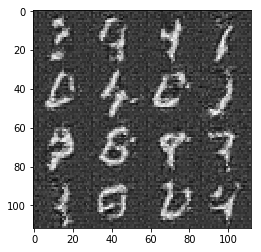

Epoch 2/10... Discriminator Loss: 0.0777... Generator Loss: 3.0899
Epoch 2/10... Discriminator Loss: 0.4735... Generator Loss: 1.3797
Epoch 2/10... Discriminator Loss: 0.4131... Generator Loss: 1.6642
Epoch 2/10... Discriminator Loss: 0.2599... Generator Loss: 2.4610
Epoch 2/10... Discriminator Loss: 0.5944... Generator Loss: 2.6160
Epoch 2/10... Discriminator Loss: 0.4382... Generator Loss: 2.4194
Epoch 2/10... Discriminator Loss: 1.6479... Generator Loss: 4.9313
Epoch 2/10... Discriminator Loss: 1.2122... Generator Loss: 5.2347
Epoch 2/10... Discriminator Loss: 0.6850... Generator Loss: 0.9267
Epoch 2/10... Discriminator Loss: 0.2792... Generator Loss: 1.7318


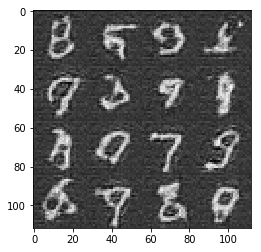

Epoch 2/10... Discriminator Loss: 1.2483... Generator Loss: 0.4842
Epoch 2/10... Discriminator Loss: 0.1184... Generator Loss: 2.8952
Epoch 2/10... Discriminator Loss: 0.1681... Generator Loss: 2.2541
Epoch 2/10... Discriminator Loss: 0.0806... Generator Loss: 3.4802
Epoch 2/10... Discriminator Loss: 0.0607... Generator Loss: 3.7011
Epoch 2/10... Discriminator Loss: 0.1169... Generator Loss: 2.8341
Epoch 2/10... Discriminator Loss: 0.0354... Generator Loss: 4.5399
Epoch 2/10... Discriminator Loss: 0.0286... Generator Loss: 5.5048
Epoch 2/10... Discriminator Loss: 0.0060... Generator Loss: 7.0815
Epoch 2/10... Discriminator Loss: 0.0100... Generator Loss: 5.9403


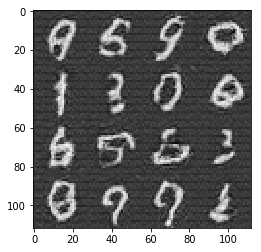

Epoch 2/10... Discriminator Loss: 0.0529... Generator Loss: 3.5550
Epoch 2/10... Discriminator Loss: 0.0365... Generator Loss: 3.9983
Epoch 2/10... Discriminator Loss: 0.0107... Generator Loss: 8.5275
Epoch 2/10... Discriminator Loss: 0.0068... Generator Loss: 7.6626
Epoch 2/10... Discriminator Loss: 1.9899... Generator Loss: 0.2233
Epoch 2/10... Discriminator Loss: 1.4715... Generator Loss: 0.5250
Epoch 2/10... Discriminator Loss: 0.9553... Generator Loss: 1.1720
Epoch 2/10... Discriminator Loss: 0.8249... Generator Loss: 1.6412
Epoch 2/10... Discriminator Loss: 0.8342... Generator Loss: 0.8305
Epoch 2/10... Discriminator Loss: 0.5276... Generator Loss: 2.3258


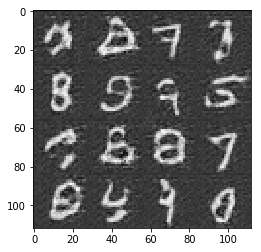

Epoch 2/10... Discriminator Loss: 0.3502... Generator Loss: 2.3092
Epoch 2/10... Discriminator Loss: 0.3359... Generator Loss: 1.8749
Epoch 2/10... Discriminator Loss: 3.2128... Generator Loss: 0.0593
Epoch 2/10... Discriminator Loss: 0.4230... Generator Loss: 1.5463
Epoch 2/10... Discriminator Loss: 0.4577... Generator Loss: 1.3942
Epoch 2/10... Discriminator Loss: 0.3298... Generator Loss: 2.2564
Epoch 2/10... Discriminator Loss: 0.2856... Generator Loss: 1.8459
Epoch 2/10... Discriminator Loss: 0.1564... Generator Loss: 2.6629
Epoch 2/10... Discriminator Loss: 1.5394... Generator Loss: 0.3403
Epoch 2/10... Discriminator Loss: 0.2160... Generator Loss: 2.5631


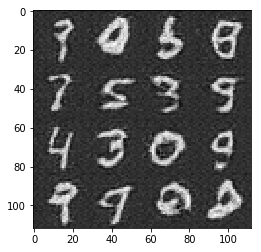

Epoch 2/10... Discriminator Loss: 0.2918... Generator Loss: 1.8627
Epoch 2/10... Discriminator Loss: 0.1358... Generator Loss: 2.6526
Epoch 2/10... Discriminator Loss: 0.2329... Generator Loss: 1.9914
Epoch 2/10... Discriminator Loss: 0.1184... Generator Loss: 2.9007
Epoch 2/10... Discriminator Loss: 0.0821... Generator Loss: 3.8657
Epoch 2/10... Discriminator Loss: 0.0388... Generator Loss: 4.4170
Epoch 2/10... Discriminator Loss: 0.0396... Generator Loss: 4.5462
Epoch 2/10... Discriminator Loss: 0.0757... Generator Loss: 3.2368
Epoch 2/10... Discriminator Loss: 0.1387... Generator Loss: 2.4922
Epoch 2/10... Discriminator Loss: 11.1350... Generator Loss: 12.0985


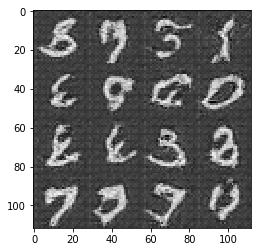

Epoch 2/10... Discriminator Loss: 0.5267... Generator Loss: 2.4284
Epoch 2/10... Discriminator Loss: 0.7305... Generator Loss: 0.9202
Epoch 2/10... Discriminator Loss: 0.3704... Generator Loss: 2.0681
Epoch 2/10... Discriminator Loss: 0.4149... Generator Loss: 1.6439
Epoch 2/10... Discriminator Loss: 0.3820... Generator Loss: 1.5237
Epoch 2/10... Discriminator Loss: 0.4369... Generator Loss: 1.4951
Epoch 2/10... Discriminator Loss: 0.6787... Generator Loss: 2.5855
Epoch 2/10... Discriminator Loss: 0.3520... Generator Loss: 2.0854
Epoch 2/10... Discriminator Loss: 0.2655... Generator Loss: 2.2361
Epoch 2/10... Discriminator Loss: 0.3851... Generator Loss: 1.6041


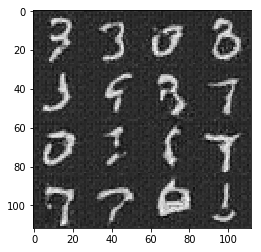

Epoch 2/10... Discriminator Loss: 0.2761... Generator Loss: 1.7755
Epoch 2/10... Discriminator Loss: 0.0966... Generator Loss: 3.1364
Epoch 2/10... Discriminator Loss: 0.0573... Generator Loss: 3.7457
Epoch 2/10... Discriminator Loss: 2.3394... Generator Loss: 0.1593
Epoch 2/10... Discriminator Loss: 0.8639... Generator Loss: 2.5631
Epoch 2/10... Discriminator Loss: 0.5552... Generator Loss: 1.2347
Epoch 2/10... Discriminator Loss: 0.3785... Generator Loss: 1.8157
Epoch 2/10... Discriminator Loss: 0.1820... Generator Loss: 3.3928
Epoch 2/10... Discriminator Loss: 0.2240... Generator Loss: 2.0576
Epoch 2/10... Discriminator Loss: 0.0492... Generator Loss: 4.3383


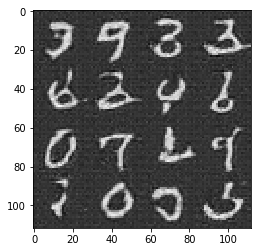

Epoch 2/10... Discriminator Loss: 0.1022... Generator Loss: 3.1516
Epoch 2/10... Discriminator Loss: 0.0949... Generator Loss: 3.1665
Epoch 2/10... Discriminator Loss: 1.8190... Generator Loss: 0.2262
Epoch 2/10... Discriminator Loss: 0.5695... Generator Loss: 1.2126
Epoch 2/10... Discriminator Loss: 0.3825... Generator Loss: 1.7231
Epoch 2/10... Discriminator Loss: 0.3584... Generator Loss: 1.5292
Epoch 2/10... Discriminator Loss: 0.4008... Generator Loss: 1.4622
Epoch 2/10... Discriminator Loss: 0.0508... Generator Loss: 4.6016
Epoch 2/10... Discriminator Loss: 0.2143... Generator Loss: 2.1028
Epoch 2/10... Discriminator Loss: 0.1471... Generator Loss: 2.5214


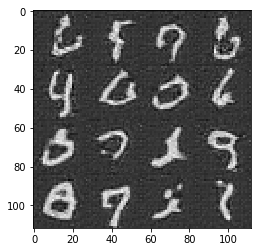

Epoch 2/10... Discriminator Loss: 0.1258... Generator Loss: 2.6140
Epoch 2/10... Discriminator Loss: 0.9062... Generator Loss: 0.8313
Epoch 2/10... Discriminator Loss: 3.5764... Generator Loss: 6.7598
Epoch 2/10... Discriminator Loss: 0.4983... Generator Loss: 1.5312
Epoch 2/10... Discriminator Loss: 1.0146... Generator Loss: 0.6967


KeyboardInterrupt: 

In [69]:
batch_size = 64
z_dim = 100
learning_rate = 1e-3
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.3438
Epoch 1/1... Discriminator Loss: 0.4038... Generator Loss: 14.8718
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 0.5407... Generator Loss: 1.3003
Epoch 1/1... Discriminator Loss: 0.1022... Generator Loss: 4.2547
Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 1.0955
Epoch 1/1... Discriminator Loss: 0.2182... Generator Loss: 5.1045
Epoch 1/1... Discriminator Loss: 0.3855... Generator Loss: 2.0700
Epoch 1/1... Discriminator Loss: 0.7454... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 0.1501... Generator Loss: 2.3398


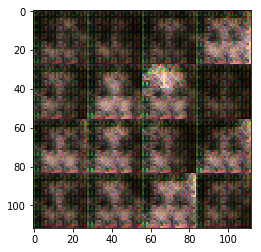

Epoch 1/1... Discriminator Loss: 0.2447... Generator Loss: 1.7311
Epoch 1/1... Discriminator Loss: 0.1318... Generator Loss: 2.8625
Epoch 1/1... Discriminator Loss: 0.3697... Generator Loss: 2.6659
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.4281
Epoch 1/1... Discriminator Loss: 0.3691... Generator Loss: 5.7817
Epoch 1/1... Discriminator Loss: 0.1668... Generator Loss: 2.7483
Epoch 1/1... Discriminator Loss: 1.5401... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 1.0397... Generator Loss: 1.8868
Epoch 1/1... Discriminator Loss: 1.5581... Generator Loss: 1.8691


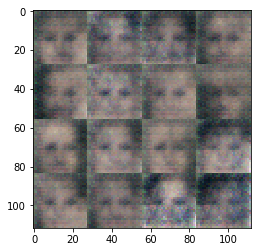

Epoch 1/1... Discriminator Loss: 1.7827... Generator Loss: 3.5005
Epoch 1/1... Discriminator Loss: 0.3302... Generator Loss: 2.2440
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.3550
Epoch 1/1... Discriminator Loss: 0.5382... Generator Loss: 1.6438
Epoch 1/1... Discriminator Loss: 0.6761... Generator Loss: 1.3624
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.3571
Epoch 1/1... Discriminator Loss: 0.1575... Generator Loss: 5.3426
Epoch 1/1... Discriminator Loss: 0.1136... Generator Loss: 7.3957
Epoch 1/1... Discriminator Loss: 2.9415... Generator Loss: 0.0702
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.8270


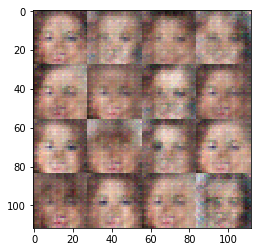

Epoch 1/1... Discriminator Loss: 0.2322... Generator Loss: 3.2544
Epoch 1/1... Discriminator Loss: 2.3788... Generator Loss: 2.4903
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 1.0431
Epoch 1/1... Discriminator Loss: 0.3593... Generator Loss: 1.9216
Epoch 1/1... Discriminator Loss: 0.8158... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 0.2883... Generator Loss: 2.1431
Epoch 1/1... Discriminator Loss: 0.8632... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 0.0393... Generator Loss: 6.1820
Epoch 1/1... Discriminator Loss: 1.8946... Generator Loss: 3.1352
Epoch 1/1... Discriminator Loss: 0.5466... Generator Loss: 2.7687


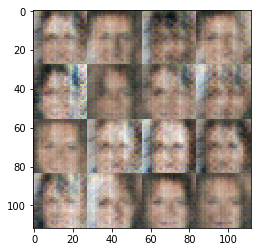

Epoch 1/1... Discriminator Loss: 0.9057... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 0.3042... Generator Loss: 7.0034
Epoch 1/1... Discriminator Loss: 0.3179... Generator Loss: 1.8296
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.5340
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 1.0525
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 3.1615... Generator Loss: 6.4609
Epoch 1/1... Discriminator Loss: 0.5987... Generator Loss: 4.0011
Epoch 1/1... Discriminator Loss: 0.5479... Generator Loss: 1.5518
Epoch 1/1... Discriminator Loss: 1.5653... Generator Loss: 4.4498


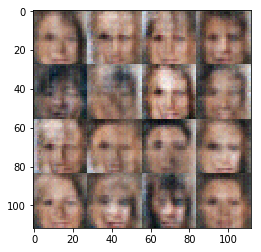

Epoch 1/1... Discriminator Loss: 0.6522... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 0.8243... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 0.4727... Generator Loss: 4.2877
Epoch 1/1... Discriminator Loss: 0.4726... Generator Loss: 1.6587
Epoch 1/1... Discriminator Loss: 0.2400... Generator Loss: 2.9617
Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 1.4391
Epoch 1/1... Discriminator Loss: 0.6223... Generator Loss: 1.3468
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.4282
Epoch 1/1... Discriminator Loss: 0.9088... Generator Loss: 2.3304


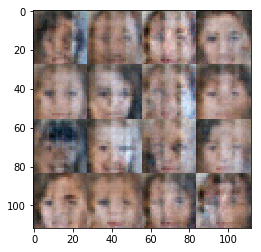

Epoch 1/1... Discriminator Loss: 0.4902... Generator Loss: 1.2554
Epoch 1/1... Discriminator Loss: 0.2450... Generator Loss: 2.6174
Epoch 1/1... Discriminator Loss: 0.7041... Generator Loss: 2.6311
Epoch 1/1... Discriminator Loss: 0.2160... Generator Loss: 4.4896
Epoch 1/1... Discriminator Loss: 0.2177... Generator Loss: 2.2583
Epoch 1/1... Discriminator Loss: 0.5667... Generator Loss: 2.2764
Epoch 1/1... Discriminator Loss: 0.2064... Generator Loss: 2.4724
Epoch 1/1... Discriminator Loss: 0.4143... Generator Loss: 2.9617
Epoch 1/1... Discriminator Loss: 0.7430... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 0.5666... Generator Loss: 6.1383


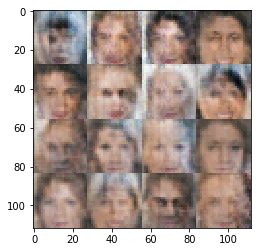

Epoch 1/1... Discriminator Loss: 0.2212... Generator Loss: 2.4239
Epoch 1/1... Discriminator Loss: 1.6618... Generator Loss: 0.2676
Epoch 1/1... Discriminator Loss: 0.8689... Generator Loss: 0.9608
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 3.2417
Epoch 1/1... Discriminator Loss: 0.5536... Generator Loss: 6.7488
Epoch 1/1... Discriminator Loss: 0.2235... Generator Loss: 3.6093
Epoch 1/1... Discriminator Loss: 0.3960... Generator Loss: 5.6019
Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 2.0936
Epoch 1/1... Discriminator Loss: 0.2859... Generator Loss: 5.5875
Epoch 1/1... Discriminator Loss: 0.5444... Generator Loss: 1.3859


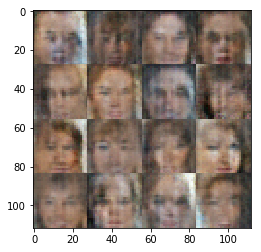

Epoch 1/1... Discriminator Loss: 0.3299... Generator Loss: 1.8960
Epoch 1/1... Discriminator Loss: 0.7358... Generator Loss: 1.3385
Epoch 1/1... Discriminator Loss: 0.0981... Generator Loss: 3.9016
Epoch 1/1... Discriminator Loss: 0.8873... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 0.6012... Generator Loss: 2.0242
Epoch 1/1... Discriminator Loss: 0.2231... Generator Loss: 2.9473
Epoch 1/1... Discriminator Loss: 0.5224... Generator Loss: 1.1940
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.4728
Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 0.1210... Generator Loss: 3.9299


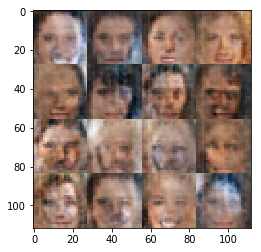

Epoch 1/1... Discriminator Loss: 0.7242... Generator Loss: 1.0036
Epoch 1/1... Discriminator Loss: 0.6072... Generator Loss: 1.0994
Epoch 1/1... Discriminator Loss: 0.6744... Generator Loss: 6.3754
Epoch 1/1... Discriminator Loss: 0.2534... Generator Loss: 1.9019
Epoch 1/1... Discriminator Loss: 1.7987... Generator Loss: 0.2300
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.3690
Epoch 1/1... Discriminator Loss: 0.3096... Generator Loss: 1.9053
Epoch 1/1... Discriminator Loss: 0.1782... Generator Loss: 2.7961
Epoch 1/1... Discriminator Loss: 1.6045... Generator Loss: 7.2052
Epoch 1/1... Discriminator Loss: 0.7126... Generator Loss: 1.1210


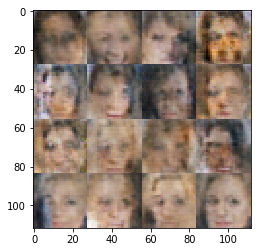

Epoch 1/1... Discriminator Loss: 1.6912... Generator Loss: 4.6230
Epoch 1/1... Discriminator Loss: 0.6107... Generator Loss: 1.1586
Epoch 1/1... Discriminator Loss: 0.7701... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 0.4738... Generator Loss: 1.3938
Epoch 1/1... Discriminator Loss: 0.2449... Generator Loss: 2.1423
Epoch 1/1... Discriminator Loss: 0.1762... Generator Loss: 2.8935
Epoch 1/1... Discriminator Loss: 0.7679... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 0.0712... Generator Loss: 4.7723
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 0.5146
Epoch 1/1... Discriminator Loss: 0.2801... Generator Loss: 2.1996


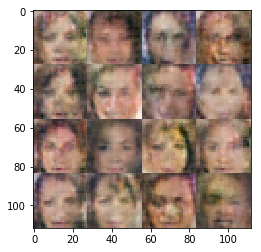

Epoch 1/1... Discriminator Loss: 0.6821... Generator Loss: 1.1479
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.4766
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 3.8022
Epoch 1/1... Discriminator Loss: 0.4726... Generator Loss: 1.5313
Epoch 1/1... Discriminator Loss: 0.5724... Generator Loss: 2.6501
Epoch 1/1... Discriminator Loss: 0.5419... Generator Loss: 1.2285
Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 1.9414... Generator Loss: 0.2596
Epoch 1/1... Discriminator Loss: 0.6519... Generator Loss: 1.3380
Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 2.5133


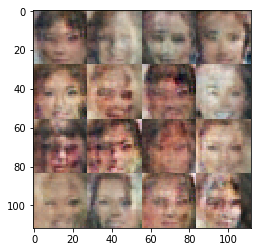

Epoch 1/1... Discriminator Loss: 0.9325... Generator Loss: 3.6786
Epoch 1/1... Discriminator Loss: 0.3706... Generator Loss: 1.6179
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 0.3487... Generator Loss: 3.4290
Epoch 1/1... Discriminator Loss: 0.2234... Generator Loss: 3.4540
Epoch 1/1... Discriminator Loss: 0.2547... Generator Loss: 2.1761
Epoch 1/1... Discriminator Loss: 1.0678... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 1.3643
Epoch 1/1... Discriminator Loss: 0.3456... Generator Loss: 1.9129
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 0.6244


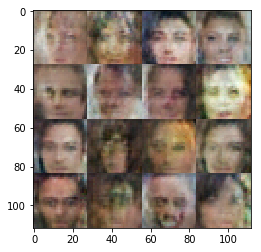

Epoch 1/1... Discriminator Loss: 0.6984... Generator Loss: 1.1203
Epoch 1/1... Discriminator Loss: 0.3022... Generator Loss: 2.0131
Epoch 1/1... Discriminator Loss: 0.3161... Generator Loss: 1.9811
Epoch 1/1... Discriminator Loss: 0.3532... Generator Loss: 1.8836
Epoch 1/1... Discriminator Loss: 0.1192... Generator Loss: 2.9336
Epoch 1/1... Discriminator Loss: 0.2207... Generator Loss: 2.4389
Epoch 1/1... Discriminator Loss: 0.2048... Generator Loss: 2.2677
Epoch 1/1... Discriminator Loss: 3.5536... Generator Loss: 1.4437
Epoch 1/1... Discriminator Loss: 0.4619... Generator Loss: 1.6289
Epoch 1/1... Discriminator Loss: 0.6490... Generator Loss: 1.5410


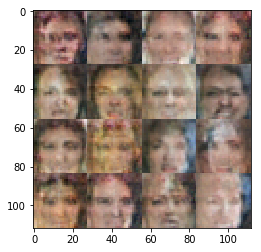

Epoch 1/1... Discriminator Loss: 0.5354... Generator Loss: 1.3769
Epoch 1/1... Discriminator Loss: 0.3734... Generator Loss: 1.9213
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.4728
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 4.5966
Epoch 1/1... Discriminator Loss: 2.2781... Generator Loss: 0.1428
Epoch 1/1... Discriminator Loss: 0.7889... Generator Loss: 1.6499
Epoch 1/1... Discriminator Loss: 0.3450... Generator Loss: 1.8252
Epoch 1/1... Discriminator Loss: 0.7254... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 0.6268... Generator Loss: 9.0648
Epoch 1/1... Discriminator Loss: 0.9883... Generator Loss: 5.9846


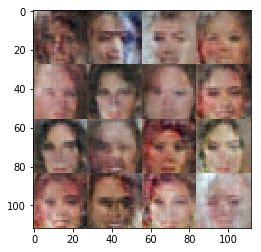

Epoch 1/1... Discriminator Loss: 0.5869... Generator Loss: 1.3135
Epoch 1/1... Discriminator Loss: 0.2272... Generator Loss: 3.3908
Epoch 1/1... Discriminator Loss: 0.0543... Generator Loss: 5.9101
Epoch 1/1... Discriminator Loss: 2.0061... Generator Loss: 0.2126
Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 0.7056... Generator Loss: 1.0498
Epoch 1/1... Discriminator Loss: 0.1050... Generator Loss: 3.7685
Epoch 1/1... Discriminator Loss: 0.4622... Generator Loss: 2.0511
Epoch 1/1... Discriminator Loss: 0.4353... Generator Loss: 1.5042
Epoch 1/1... Discriminator Loss: 0.2744... Generator Loss: 2.3174


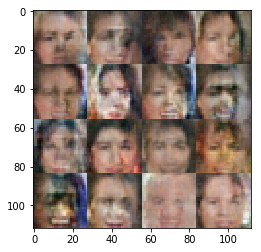

Epoch 1/1... Discriminator Loss: 2.1322... Generator Loss: 0.2333
Epoch 1/1... Discriminator Loss: 1.1292... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 2.0102... Generator Loss: 0.2053
Epoch 1/1... Discriminator Loss: 1.6078... Generator Loss: 0.3719
Epoch 1/1... Discriminator Loss: 0.6962... Generator Loss: 0.9866
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.5283
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.9780
Epoch 1/1... Discriminator Loss: 0.7602... Generator Loss: 1.0725
Epoch 1/1... Discriminator Loss: 0.4245... Generator Loss: 6.3820
Epoch 1/1... Discriminator Loss: 0.2280... Generator Loss: 4.2275


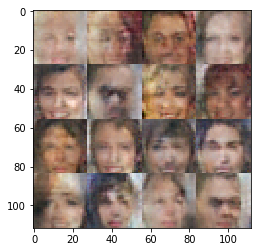

Epoch 1/1... Discriminator Loss: 0.9901... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 0.1784... Generator Loss: 3.8625
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 0.5763... Generator Loss: 3.2970
Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 0.4235... Generator Loss: 2.1923
Epoch 1/1... Discriminator Loss: 0.1240... Generator Loss: 4.0789
Epoch 1/1... Discriminator Loss: 3.4534... Generator Loss: 0.0704
Epoch 1/1... Discriminator Loss: 0.5783... Generator Loss: 1.2944


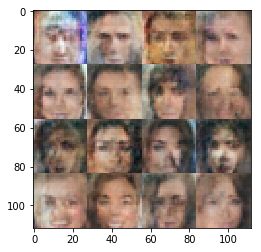

Epoch 1/1... Discriminator Loss: 1.7683... Generator Loss: 0.2853
Epoch 1/1... Discriminator Loss: 0.2422... Generator Loss: 2.4111
Epoch 1/1... Discriminator Loss: 0.2130... Generator Loss: 5.5941
Epoch 1/1... Discriminator Loss: 0.1704... Generator Loss: 2.5525
Epoch 1/1... Discriminator Loss: 1.6124... Generator Loss: 1.5821
Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 0.6108
Epoch 1/1... Discriminator Loss: 0.7643... Generator Loss: 3.5552
Epoch 1/1... Discriminator Loss: 0.2631... Generator Loss: 3.2821
Epoch 1/1... Discriminator Loss: 0.6734... Generator Loss: 1.2832
Epoch 1/1... Discriminator Loss: 0.7447... Generator Loss: 1.1892


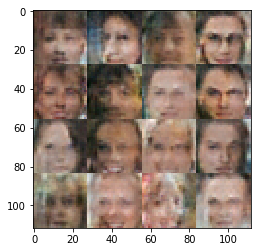

Epoch 1/1... Discriminator Loss: 0.2813... Generator Loss: 2.2853
Epoch 1/1... Discriminator Loss: 0.6396... Generator Loss: 1.1687
Epoch 1/1... Discriminator Loss: 3.1286... Generator Loss: 5.7232
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 2.5789
Epoch 1/1... Discriminator Loss: 0.8954... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 0.8043... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 0.5874... Generator Loss: 5.9735
Epoch 1/1... Discriminator Loss: 0.4835... Generator Loss: 1.3872
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 4.2605
Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 0.8402


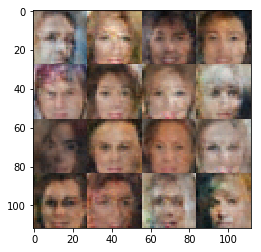

Epoch 1/1... Discriminator Loss: 0.6918... Generator Loss: 1.0243
Epoch 1/1... Discriminator Loss: 0.1959... Generator Loss: 2.9586
Epoch 1/1... Discriminator Loss: 0.3490... Generator Loss: 1.8382
Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 0.5098... Generator Loss: 1.5083
Epoch 1/1... Discriminator Loss: 0.2743... Generator Loss: 3.1624
Epoch 1/1... Discriminator Loss: 0.6249... Generator Loss: 3.5627
Epoch 1/1... Discriminator Loss: 0.7766... Generator Loss: 3.2337
Epoch 1/1... Discriminator Loss: 0.8197... Generator Loss: 0.9102
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 6.3615


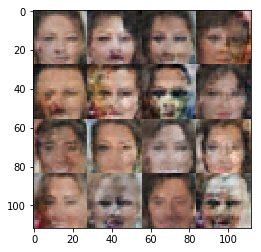

Epoch 1/1... Discriminator Loss: 0.3455... Generator Loss: 7.3752
Epoch 1/1... Discriminator Loss: 0.2122... Generator Loss: 2.9175
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 0.7909... Generator Loss: 0.9398
Epoch 1/1... Discriminator Loss: 0.8391... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.5074
Epoch 1/1... Discriminator Loss: 0.3535... Generator Loss: 2.2075
Epoch 1/1... Discriminator Loss: 0.5716... Generator Loss: 1.2161
Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 4.9386
Epoch 1/1... Discriminator Loss: 2.6694... Generator Loss: 7.2775


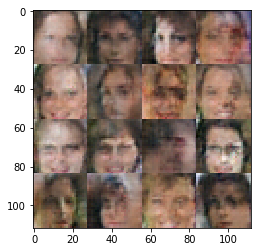

Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 0.5267... Generator Loss: 1.7793
Epoch 1/1... Discriminator Loss: 0.6856... Generator Loss: 1.1056
Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.9104... Generator Loss: 0.2531
Epoch 1/1... Discriminator Loss: 0.8332... Generator Loss: 1.0747
Epoch 1/1... Discriminator Loss: 0.6104... Generator Loss: 1.1519
Epoch 1/1... Discriminator Loss: 2.1944... Generator Loss: 0.2071
Epoch 1/1... Discriminator Loss: 0.3988... Generator Loss: 1.8505


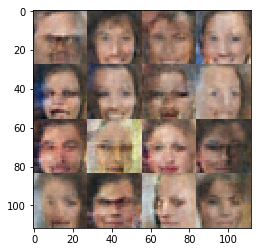

Epoch 1/1... Discriminator Loss: 0.2903... Generator Loss: 2.2202
Epoch 1/1... Discriminator Loss: 0.2056... Generator Loss: 2.5527
Epoch 1/1... Discriminator Loss: 0.8307... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 0.5964... Generator Loss: 1.4123
Epoch 1/1... Discriminator Loss: 0.7482... Generator Loss: 0.9161
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 1.5103
Epoch 1/1... Discriminator Loss: 1.7776... Generator Loss: 0.3672
Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.3504
Epoch 1/1... Discriminator Loss: 1.7883... Generator Loss: 2.6324


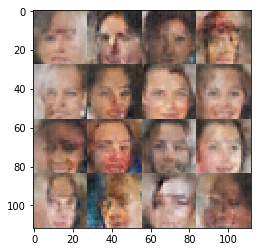

Epoch 1/1... Discriminator Loss: 0.3480... Generator Loss: 2.9741
Epoch 1/1... Discriminator Loss: 0.4231... Generator Loss: 3.7151
Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.4094
Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.4582
Epoch 1/1... Discriminator Loss: 0.2910... Generator Loss: 2.5302
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 3.3361
Epoch 1/1... Discriminator Loss: 0.3445... Generator Loss: 1.9390
Epoch 1/1... Discriminator Loss: 0.3390... Generator Loss: 1.6364
Epoch 1/1... Discriminator Loss: 0.2495... Generator Loss: 4.4225


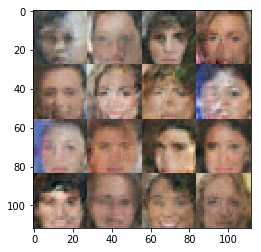

Epoch 1/1... Discriminator Loss: 1.8867... Generator Loss: 1.1716
Epoch 1/1... Discriminator Loss: 0.8667... Generator Loss: 1.8185
Epoch 1/1... Discriminator Loss: 0.7356... Generator Loss: 1.0049
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.5221
Epoch 1/1... Discriminator Loss: 0.3403... Generator Loss: 2.2580
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 3.0330
Epoch 1/1... Discriminator Loss: 1.5593... Generator Loss: 0.3713
Epoch 1/1... Discriminator Loss: 0.7321... Generator Loss: 1.2594
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.4408
Epoch 1/1... Discriminator Loss: 0.4583... Generator Loss: 2.8339


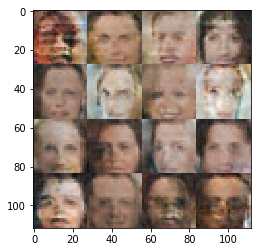

Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 0.9264... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 0.6386... Generator Loss: 1.2612
Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 1.5563
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 1.4356
Epoch 1/1... Discriminator Loss: 1.8826... Generator Loss: 0.2142
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 0.7582... Generator Loss: 1.1173
Epoch 1/1... Discriminator Loss: 0.6879... Generator Loss: 3.2880
Epoch 1/1... Discriminator Loss: 0.4422... Generator Loss: 2.2378


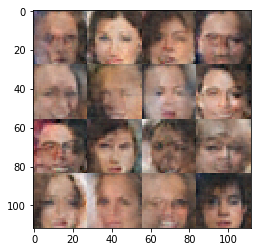

Epoch 1/1... Discriminator Loss: 0.6139... Generator Loss: 1.3371
Epoch 1/1... Discriminator Loss: 0.8803... Generator Loss: 1.9716
Epoch 1/1... Discriminator Loss: 2.8009... Generator Loss: 0.0960
Epoch 1/1... Discriminator Loss: 1.7581... Generator Loss: 0.3354
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 0.8624... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.5187
Epoch 1/1... Discriminator Loss: 0.7787... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 0.5548... Generator Loss: 1.4400


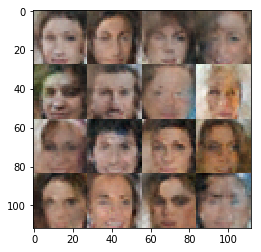

Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 0.6644... Generator Loss: 1.1491
Epoch 1/1... Discriminator Loss: 0.2808... Generator Loss: 1.9776
Epoch 1/1... Discriminator Loss: 1.5305... Generator Loss: 0.4578
Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 0.7029... Generator Loss: 1.0428
Epoch 1/1... Discriminator Loss: 0.9395... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 1.1929
Epoch 1/1... Discriminator Loss: 0.8446... Generator Loss: 2.5618
Epoch 1/1... Discriminator Loss: 0.6248... Generator Loss: 1.5662


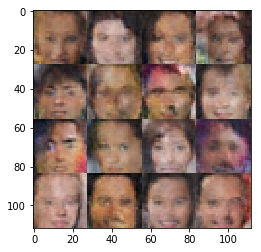

Epoch 1/1... Discriminator Loss: 0.6917... Generator Loss: 1.2624
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.4682
Epoch 1/1... Discriminator Loss: 0.8910... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 0.7572... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 0.7554... Generator Loss: 1.1107
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 0.7475... Generator Loss: 1.6001
Epoch 1/1... Discriminator Loss: 0.8426... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.5286


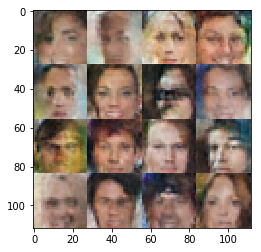

Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 2.8149... Generator Loss: 3.4876
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 1.4982
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 0.9461... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 0.7923... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 0.6382... Generator Loss: 1.2095
Epoch 1/1... Discriminator Loss: 0.7450... Generator Loss: 1.1966
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 0.5421


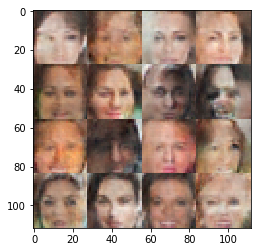

Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 1.3280
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.3613
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.6531... Generator Loss: 0.2857
Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 0.6810


In [70]:
batch_size = 64
z_dim = 100
learning_rate = 1e-3
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.